# Problema de Negócio:

* Uma empresa de energia solar quer entender o impacto das condições meteorológicas na geração de energia solar. O objetivo é desenvolver um modelo que possa prever a Irradiância Global Horizontal (GHI) com base na umidade relativa do ar e na temperatura ambiente. Isso ajudará a empresa a otimizar a eficiência dos painéis solares em diferentes condições climáticas.

# Descrição das variáveis:

* TS: Timestamp (data e hora da medição).
* RH: Umidade relativa do ar (%).
* TAMB: Temperatura ambiente (°C).
* GHI: Irradiância global horizontal (W/m²).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import(
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

* Tratamento inicial dos dados:

In [2]:
# Carregando o arquivo:
df = pd.read_csv('weather_data.csv')

# Transformando a coluna 'TS' no formato datetime:
df['TS'] = pd.to_datetime(df['TS'])

# Criando uma variável para os registros mensais:
df_mensal = df.copy()
df_mensal.set_index('TS', inplace=True)
df_mensal = df_mensal.resample('M').mean()

# Criando uma variável para os registros diarios:
df_diario = df.copy()
df_diario.set_index('TS', inplace=True)
df_diario = df_diario.resample('D').mean()

# Colocando a variável 'TS' como indice do nosso dataframe:
df.set_index('TS', inplace=True)

df

/tmp/ipykernel_6360/392261222.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


,RH,TAMB,GHI
TS,,,
2024-04-10 00:00:00,95.199997,24.900000,-1.0
2024-04-10 00:01:00,95.000000,24.900000,-1.0
2024-04-10 00:02:00,95.000000,24.900000,-0.5
2024-04-10 00:03:00,95.099998,24.900000,-0.5
2024-04-10 00:04:00,95.500000,24.900000,-0.5
...,...,...,...
2024-10-14 21:21:00,85.900002,23.799999,-0.5
2024-10-14 21:22:00,85.900002,23.799999,-0.5
2024-10-14 21:23:00,86.099998,23.799999,-0.5


In [3]:
df_mensal

,RH,TAMB,GHI
TS,,,
2024-04-30,89.434531,26.138483,172.665590
2024-05-31,87.293172,26.499536,191.091011
2024-06-30,84.662574,26.018147,221.243582
2024-07-31,73.553466,22.438278,196.695653
2024-08-31,71.869000,26.003777,262.255236
2024-09-30,67.606602,26.906787,275.334120
2024-10-31,70.799100,26.998220,272.110622


In [4]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,NaN,NaN,NaN
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


In [5]:
# Substituindo os valores NaN do df_diario:
df_diario = df_diario.apply(lambda col: col.fillna(col.mean()), axis=0)

In [6]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,76.434039,25.586265,230.307977
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


* Vamos verificar os tipos de dados e se há valores ausentes:

In [7]:
df_mensal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2024-04-30 to 2024-10-31
Freq: ME
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RH      7 non-null      float64
 1   TAMB    7 non-null      float64
 2   GHI     7 non-null      float64
dtypes: float64(3)
memory usage: 224.0 bytes


* Vamos fazer uma descrição do dataframe:

In [8]:
df.describe()

,RH,TAMB,GHI
count,224783.000000,224783.000000,224783.000000
mean,76.238337,25.679468,233.720984
std,18.038884,4.793512,331.019706
min,30.900000,2.200000,-20.000000
25%,62.599998,23.299999,-0.500000
50%,80.199997,25.100000,0.500000
75%,93.000000,29.200001,432.500000
max,499.899994,465.100006,1417.500000


* Podemos perceber que algumas variáves apresentam inconsistência: 
    1. A variável RH deveria ir de 0% a 100%, entretanto, podemos perceber que seu valor máximo é de quase 500%.
    2. A temperatura ambiente para o nordeste está beirando valores improvaveis para tal região.

* Vamos fazer um tratamento de outliers para as variáveis: RH e TAMB:

In [9]:
# Sabemos que os limites da umidade relativa é de 0% a 100%: 
limite_inferior_RH = 0
limite_superior_RH = 100

outliers_RH = (df['RH'] < limite_inferior_RH) | (df['RH'] > limite_superior_RH)

In [10]:
# Agora vamos tratar os outliers da temperatura ambiente. 
# O aceitável é uma temperatura ambiente entre 20°C e um pouco mais de 30°C.
IQR_TAMB = df['TAMB'].quantile(0.75) - df['TAMB'].quantile(0.25)
limite_inferior_TAMB = df['TAMB'].quantile(0.05) # 95% dos dados estão acima desse quartil 
limite_superior_TAMB = df['TAMB'].quantile(0.75) + (1.5 * IQR_TAMB)
outliers_TAMB = (df['TAMB'] <= limite_inferior_TAMB) | (df['TAMB'] >= limite_superior_TAMB)
limite_inferior_TAMB, limite_superior_TAMB

(20.700000762939453, 38.05000305175781)

In [11]:
IQR_GHI = df['GHI'].quantile(0.75) - df['GHI'].quantile(0.25)
limite_inferior_GHI = 0 
limite_superior_GHI = df['GHI'].quantile(0.75) + (1.5 * IQR_GHI)
outliers_GHI = (df['GHI'] <= limite_inferior_GHI) | (df['GHI'] >= limite_superior_GHI)
limite_inferior_GHI, limite_superior_GHI

(0, 1082.0)

In [12]:
# Dataframe flitrado:
outliers = (outliers_RH | outliers_TAMB | outliers_GHI)
df_limpo = df[~outliers]
df_limpo

,RH,TAMB,GHI
TS,,,
2024-04-10 00:32:00,95.000000,24.799999,0.5
2024-04-10 00:33:00,95.000000,24.799999,0.5
2024-04-10 00:34:00,95.000000,24.799999,0.5
2024-04-10 00:35:00,95.099998,24.799999,0.5
2024-04-10 00:36:00,95.300003,24.799999,0.5
...,...,...,...
2024-10-14 17:39:00,73.900002,25.900000,1.0
2024-10-14 17:40:00,73.900002,25.900000,0.5
2024-10-14 17:41:00,74.000000,25.799999,0.5


In [13]:
df_limpo.describe()

,RH,TAMB,GHI
count,113104.000000,113104.000000,113104.000000
mean,65.690337,28.563681,444.271012
std,16.894269,2.965152,324.844208
min,30.900000,20.799999,0.500000
25%,51.599998,26.500000,146.000000
50%,64.800003,29.100000,409.000000
75%,78.000000,30.900000,734.500000
max,99.599998,34.700001,1081.500000


* Agora que o DataFrame central já foi tratado, podemos apenas copiar e agrupar os dados médios mensais e diarios.

In [14]:
df_mensal = df_limpo.copy()
df_mensal = df_mensal.resample('M').mean()
df_mensal

/tmp/ipykernel_6360/2836804745.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


,RH,TAMB,GHI
TS,,,
2024-04-30,84.645961,27.398206,288.213267
2024-05-31,80.545052,28.111696,345.124145
2024-06-30,75.034508,28.249086,416.917162
2024-07-31,61.712436,28.287843,471.024593
2024-08-31,57.153633,28.855038,504.378195
2024-09-30,55.860034,29.212520,491.031709
2024-10-31,59.931409,29.284394,470.651466


In [15]:
df_mensal.describe()

,RH,TAMB,GHI
count,7.000000,7.000000,7.000000
mean,67.840433,28.485540,426.762934
std,11.926375,0.673331,81.647355
min,55.860034,27.398206,288.213267
25%,58.542521,28.180391,381.020654
50%,61.712436,28.287843,470.651466
75%,77.789780,29.033779,481.028151
max,84.645961,29.284394,504.378195


In [16]:
df_diario = df_limpo.copy()
df_diario = df_diario.resample('D').mean()
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,83.593562,27.997425,318.640200
2024-04-11,83.673241,27.834345,293.093103
2024-04-12,82.243658,28.087463,378.936578
2024-04-13,87.645034,27.190884,266.961224
2024-04-14,NaN,NaN,NaN
...,...,...,...
2024-10-10,66.363781,28.791486,441.825397
2024-10-11,57.305432,29.428691,494.770195
2024-10-12,54.990797,29.992720,453.953297


In [17]:
# Substituindo os valores NaN do df_diario:
df_diario = df_diario.apply(lambda col: col.fillna(col.mean()), axis=0)

In [18]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,83.593562,27.997425,318.640200
2024-04-11,83.673241,27.834345,293.093103
2024-04-12,82.243658,28.087463,378.936578
2024-04-13,87.645034,27.190884,266.961224
2024-04-14,65.703865,28.552930,441.302889
...,...,...,...
2024-10-10,66.363781,28.791486,441.825397
2024-10-11,57.305432,29.428691,494.770195
2024-10-12,54.990797,29.992720,453.953297


In [19]:
df_diario.describe()

,RH,TAMB,GHI
count,188.000000,188.000000,188.000000
mean,65.703865,28.552930,441.302889
std,10.455596,0.868150,94.245605
min,47.030252,23.940769,23.953846
25%,57.689506,28.360637,417.159830
50%,65.703865,28.556709,442.995792
75%,72.454522,29.067428,500.946044
max,97.655385,30.081103,598.833568


# Vamos visualizar a distribuição dos dados:

* Distribuição dos dados:

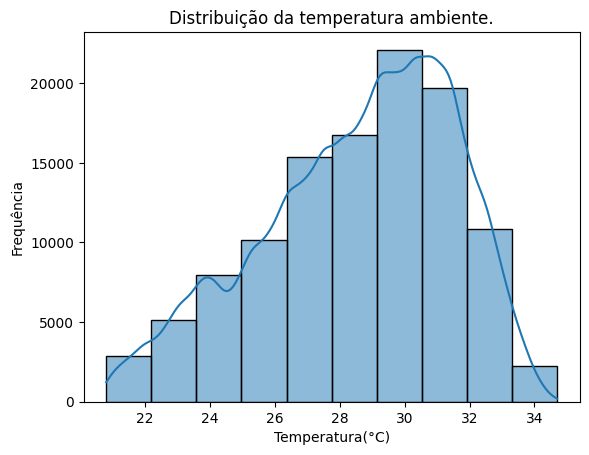

In [20]:
# Distribuição dos dados de TAMB:
sns.histplot(df_limpo['TAMB'], bins=10, kde=True)
plt.title('Distribuição da temperatura ambiente.')
plt.xlabel('Temperatura(°C)')
plt.ylabel('Frequência')
plt.show()

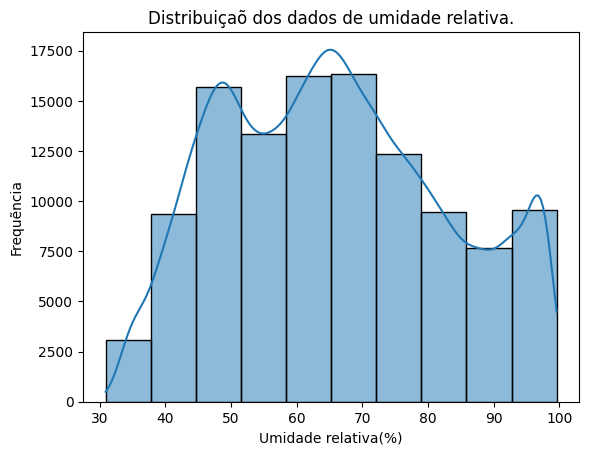

In [21]:
# Distribuição dos dados de RH:
sns.histplot(df_limpo['RH'], kde=True, bins=10)
plt.title('Distribuiçaõ dos dados de umidade relativa.')
plt.xlabel('Umidade relativa(%)')
plt.ylabel('Frequẽncia')
plt.show()

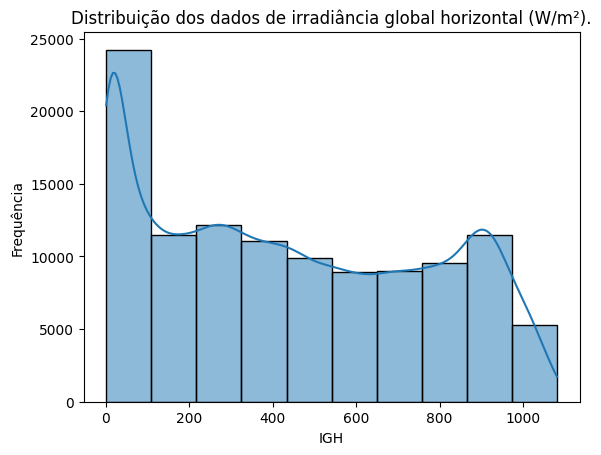

In [22]:
# Distribuição dos de GHI:
sns.histplot(df_limpo['GHI'], kde=True, bins=10)
plt.title('Distribuição dos dados de irradiância global horizontal (W/m²).')
plt.xlabel('IGH')
plt.ylabel('Frequência')
plt.show()

* Dispersão entre as variáveis RH, GHI e TAMB:

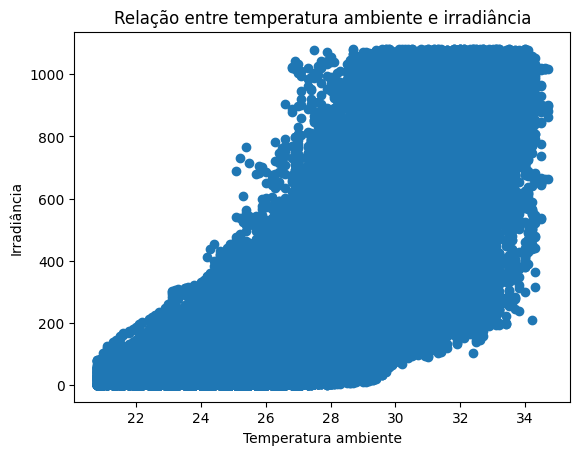

In [23]:
plt.scatter(df_limpo['TAMB'], df_limpo['GHI'])
plt.title('Relação entre temperatura ambiente e irradiância')
plt.xlabel('Temperatura ambiente')
plt.ylabel('Irradiância')
plt.show()

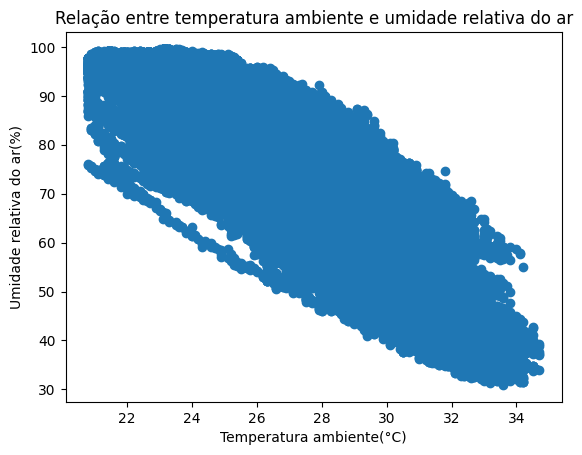

In [24]:
plt.scatter(df_limpo['TAMB'], df_limpo['RH'])
plt.title('Relação entre temperatura ambiente e umidade relativa do ar')
plt.xlabel('Temperatura ambiente(°C)')
plt.ylabel('Umidade relativa do ar(%)')
plt.show()

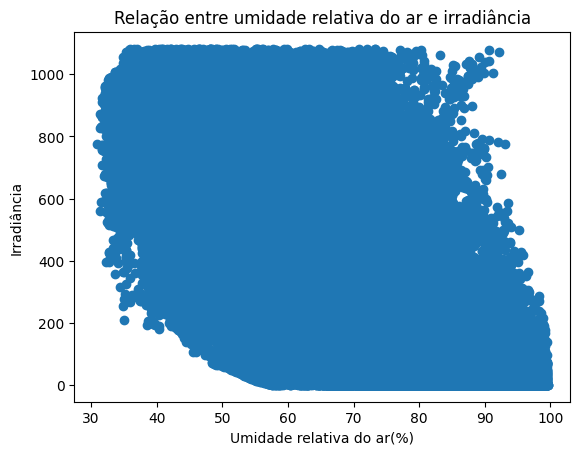

In [25]:
plt.scatter(df_limpo['RH'], df_limpo['GHI'])
plt.title('Relação entre umidade relativa do ar e irradiância')
plt.xlabel('Umidade relativa do ar(%)')
plt.ylabel('Irradiância')
plt.show()

# Vamos analisar a sazonalidade de GHI.

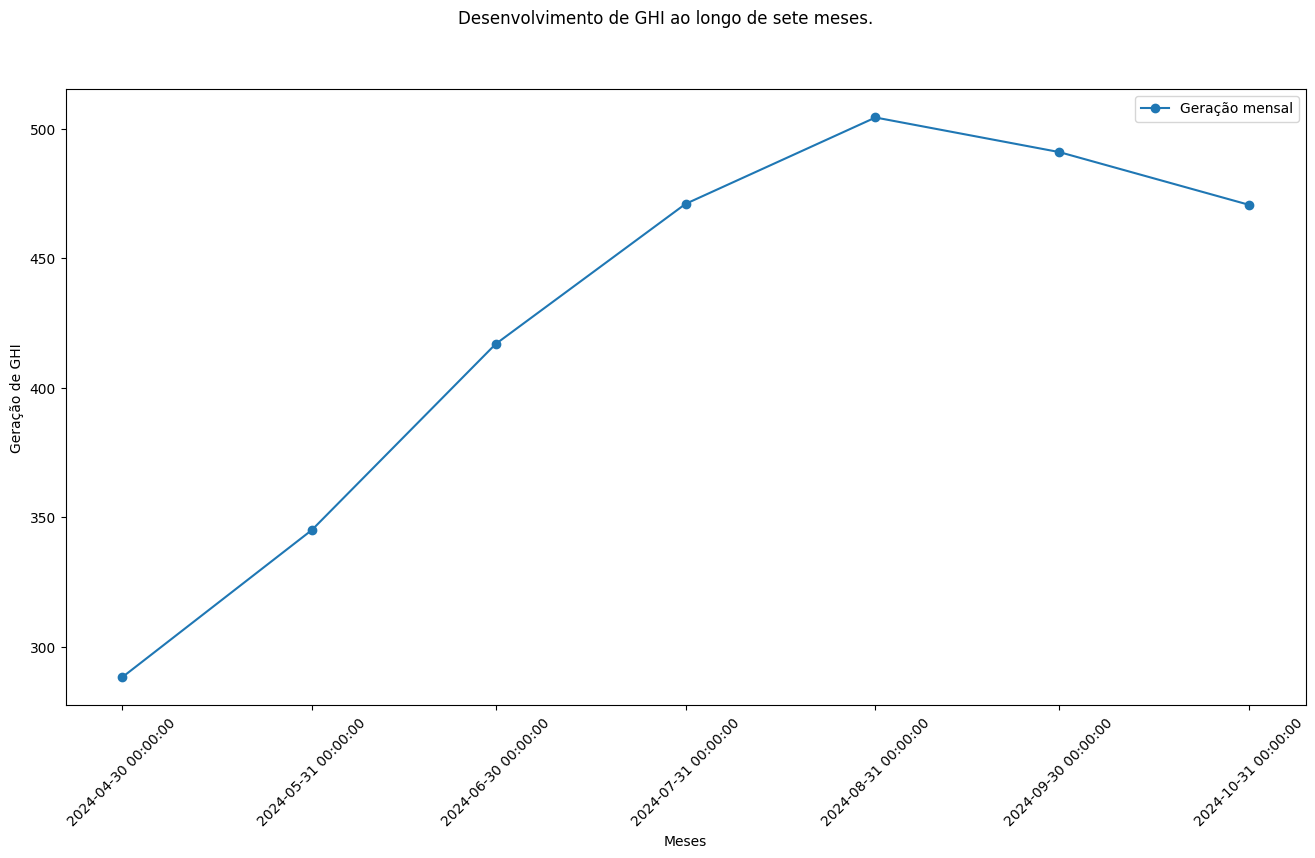

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI ao longo de sete meses.')
ax.plot(df_mensal['GHI'], label='Geração mensal', marker='o')
ax.set_xlabel('Meses')
ax.set_ylabel('Geração de GHI')
ax.set_xticks(df_mensal['GHI'].index) 
ax.set_xticklabels(df_mensal['GHI'].index, rotation=45)  
ax.legend()
plt.show()

* Vamos analisar como se comportou a irradiação no mês de abril:

/tmp/ipykernel_6360/1079403853.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_abril['GHI'].index.strftime('%b-%Y'), rotation=45)


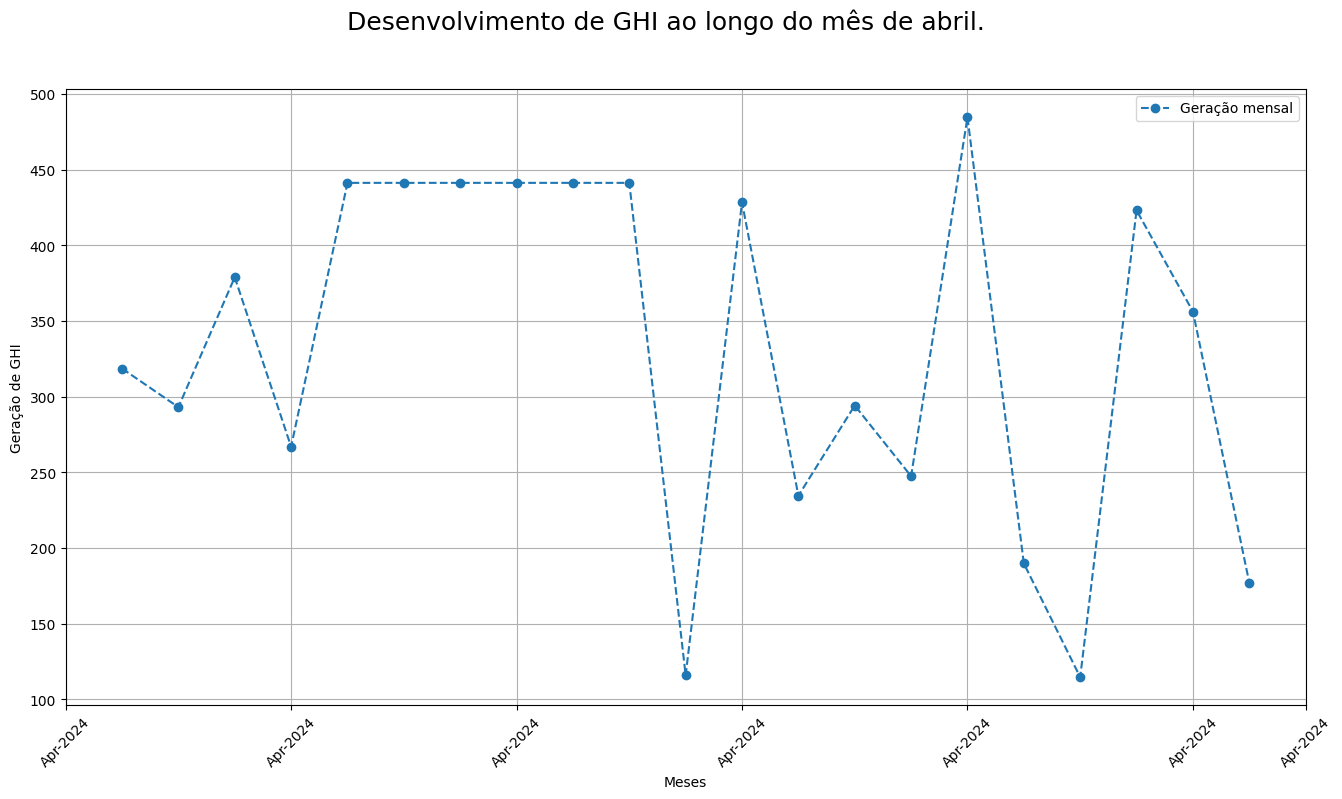

In [27]:
# Primeiro selecionamos somente os registros do mês de abril:
df_abril = df_diario[df_diario.index.month == 4]

fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI ao longo do mês de abril.', fontsize=18)
ax.plot(df_abril['GHI'], label='Geração mensal', marker='o', linestyle='--')
ax.set_xlabel('Meses')
ax.set_ylabel('Geração de GHI')
ax.set_xticklabels(df_abril['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos analisar o  comportamento da irradiação no mês de maio:

/tmp/ipykernel_6360/2742143688.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_maio['GHI'].index.strftime('%b-%Y'), rotation=45)


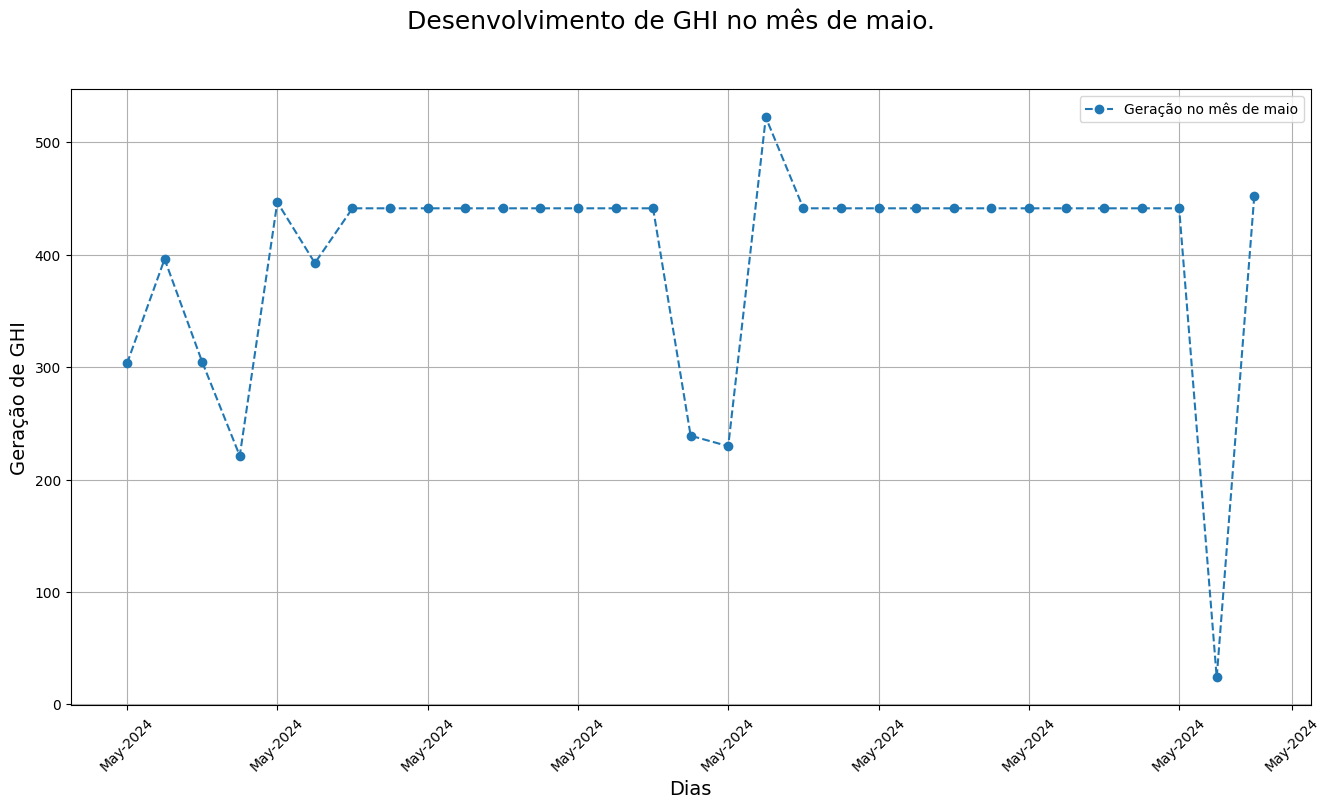

In [28]:
# Primeiro selecionamos somente os registros do mês de maio:
df_maio = df_diario[df_diario.index.month == 5]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de maio:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de maio.', fontsize=18)
ax.plot(df_maio['GHI'], label='Geração no mês de maio', marker='o',linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_maio['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos vê como se comportou o GHI no mês de junho:

/tmp/ipykernel_6360/2040283549.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_junho['GHI'].index.strftime('%b-%Y'), rotation=45)


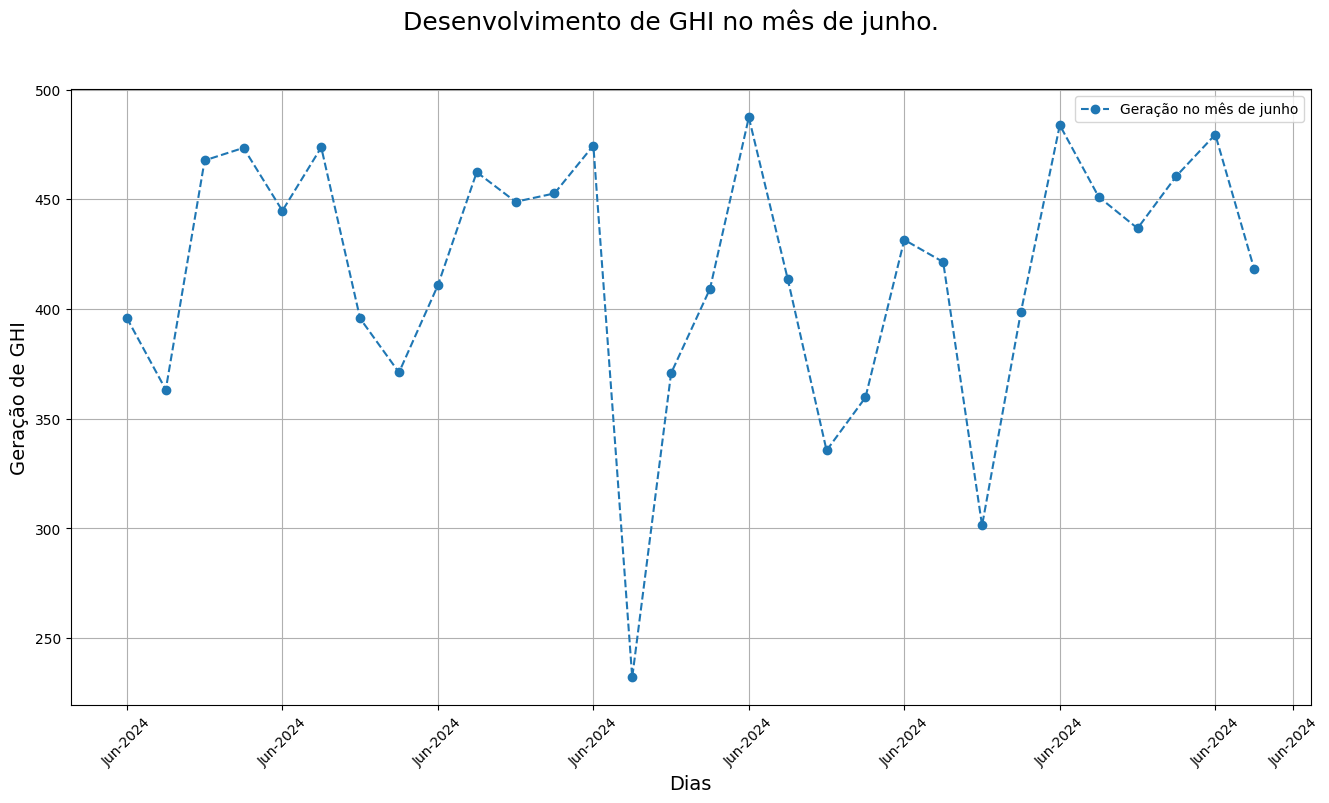

In [29]:
# Primeiro selecionamos somente os registros do mês de junho:
df_junho = df_diario[df_diario.index.month == 6]

# Agora plotamos um gráfico para vê como se comportou o GHI no mês de junho:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de junho.', fontsize=18)
ax.plot(df_junho['GHI'], label='Geração no mês de junho', marker='o', linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_junho['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos vê como se comportou o GHI no mês de julho:

/tmp/ipykernel_6360/2759547434.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_julho['GHI'].index.strftime('%b-%Y'), rotation=45)


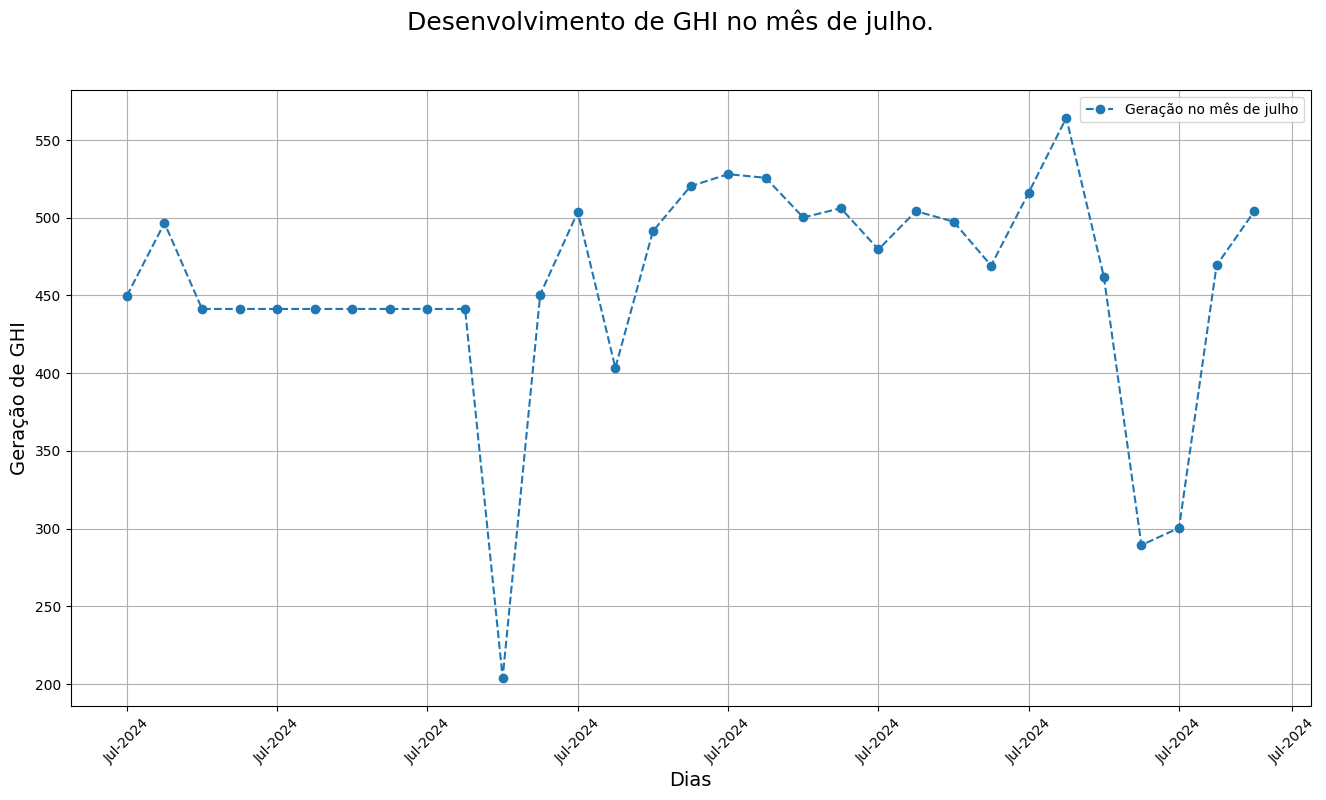

In [30]:
# Primeiro selecionamos somente os registros do mês de julho:
df_julho = df_diario[df_diario.index.month == 7]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de julho:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de julho.', fontsize=18)
ax.plot(df_julho['GHI'], label='Geração no mês de julho', marker='o', linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_julho['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Comportamento do GHI no mês de agosto:

/tmp/ipykernel_6360/1663342400.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_agosto['GHI'].index.strftime('%b-%Y'), rotation=45)


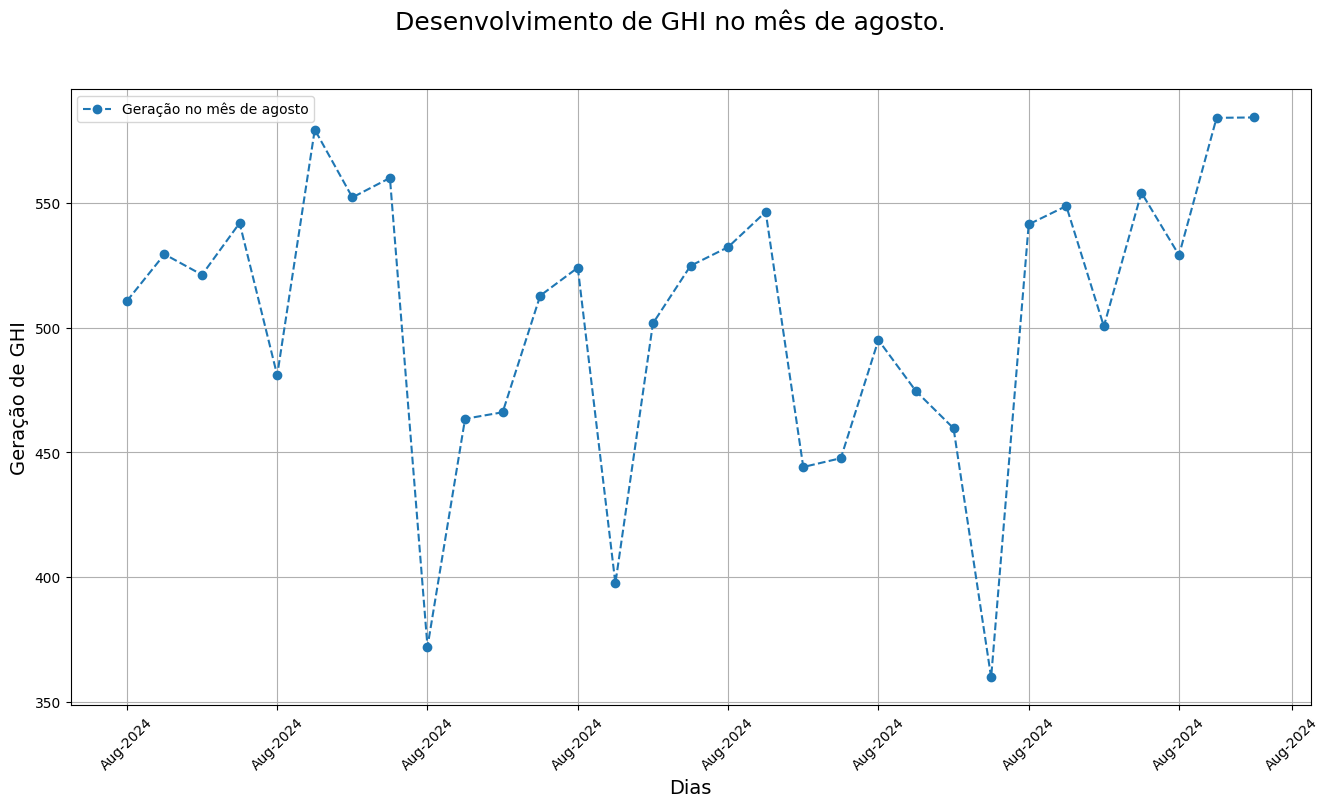

In [31]:
# Primeiro selecionamos somente os registros do mês de agosto:
df_agosto = df_diario[df_diario.index.month == 8]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de agosto:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de agosto.', fontsize=18)
ax.plot(df_agosto['GHI'], label='Geração no mês de agosto', marker='o', linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_agosto['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Agora vamos vê o desenvolvimento do GHI no mês de setembro:

/tmp/ipykernel_6360/3765630311.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_setembro['GHI'].index.strftime('%b-%Y'), rotation=45)


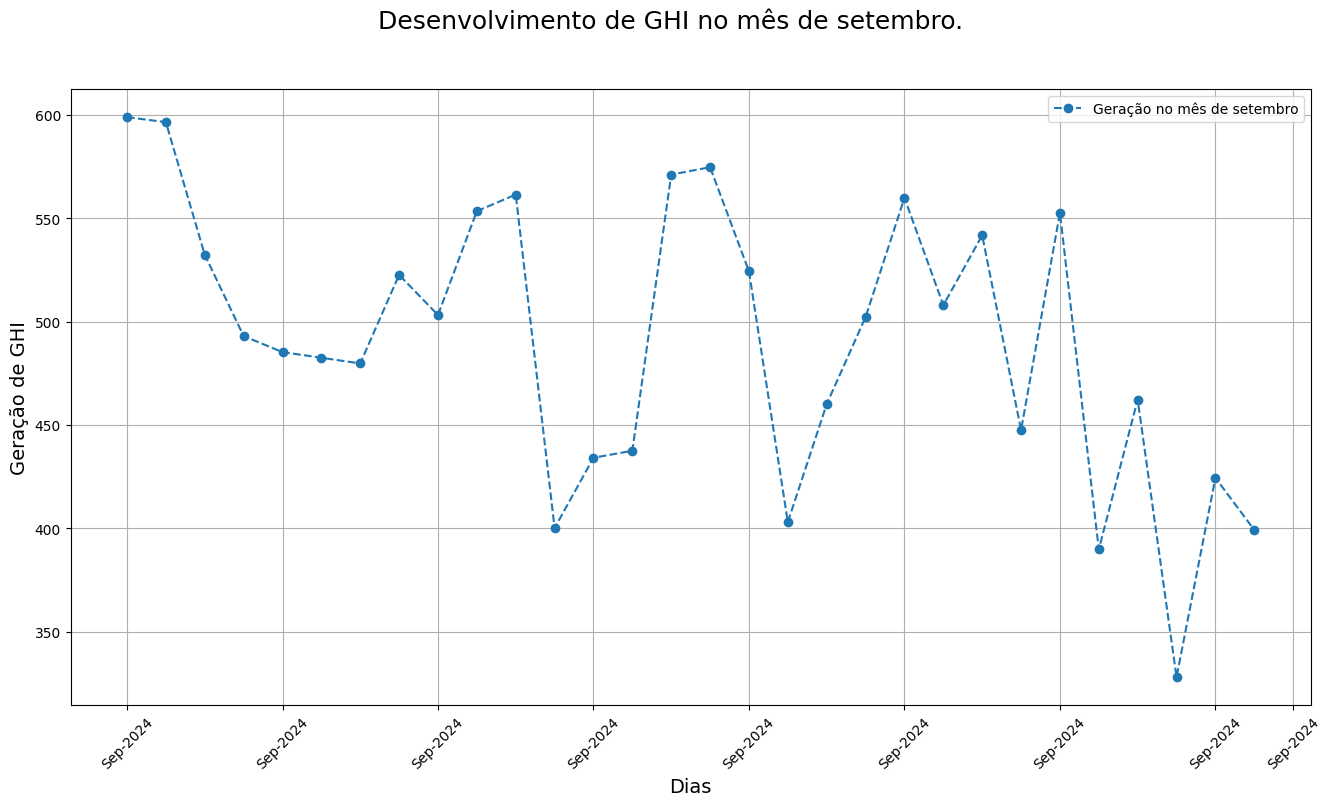

In [32]:
# Primeiro selecionamos somente os registros do mês de setembro:
df_setembro = df_diario[df_diario.index.month == 9]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de setembro:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de setembro.', fontsize=18)
ax.plot(df_setembro['GHI'], label='Geração no mês de setembro', marker='o', linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_setembro['GHI'].index.strftime('%b-%Y'), rotation=45)
ax.legend()
plt.grid(True)
plt.show()

* Desenvolvimento de GHI no mês de outubro:

/tmp/ipykernel_6360/4053619265.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_outubro['GHI'].index.strftime('%b-%Y'), rotation=45)


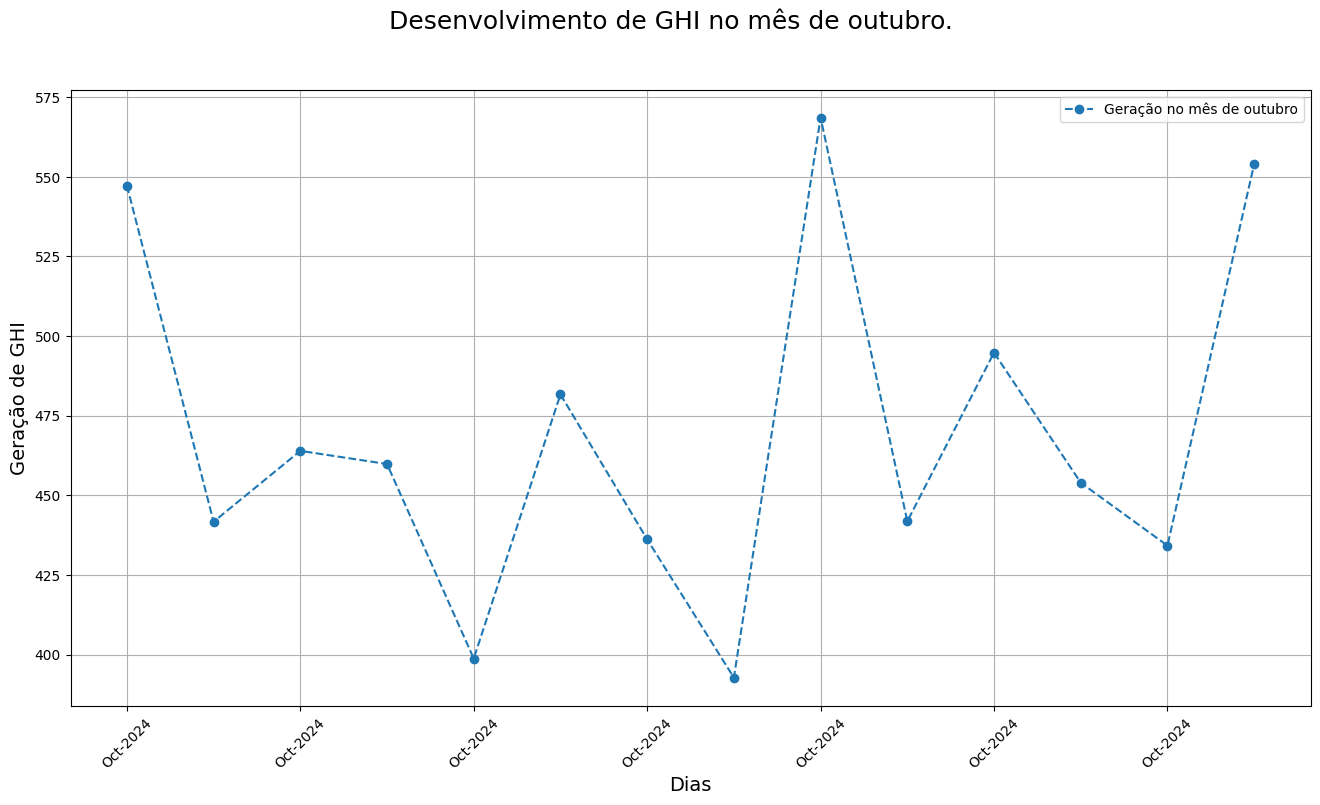

In [33]:
# Primeiro selecionamos somente os registros do mês de outubro:
df_outubro = df_diario[df_diario.index.month == 10]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de outubro:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de outubro.', fontsize=18)
ax.plot(df_outubro['GHI'], label='Geração no mês de outubro', marker='o', linestyle='--')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticklabels(df_outubro['GHI'].index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

# 2. Análise de Correlação e Sazonalidade

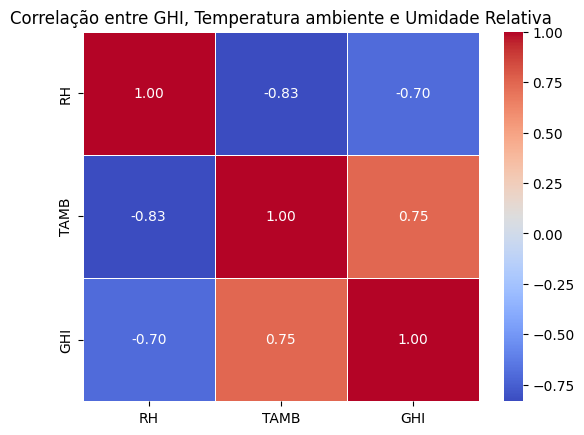

In [34]:
# Calculando a matriz de correlação das variáveis:
matriz_de_correlacao = df_limpo.corr()

# Mapa de calor para visualizar a correlação entre as variáveis:
sns.heatmap(matriz_de_correlacao, annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5)
plt.title('Correlação entre GHI, Temperatura ambiente e Umidade Relativa')
plt.show()

# 3. Feature Engineering

* Calculando médias móveis de GHI, Temperatura Ambiente e Umidade Relativa do Ar em sete meses:

Média móvel temperatura ambiente:

In [35]:
df_mensal['TAMB_MV_7M'] = df_mensal['TAMB'].rolling(window=7, min_periods=1).mean()
df_mensal['GHI_MV_7M'] = df_mensal['GHI'].rolling(window=7,min_periods=1).mean()
df_mensal['RH_MV_7M'] = df_mensal['RH'].rolling(window=7,min_periods=1).mean()

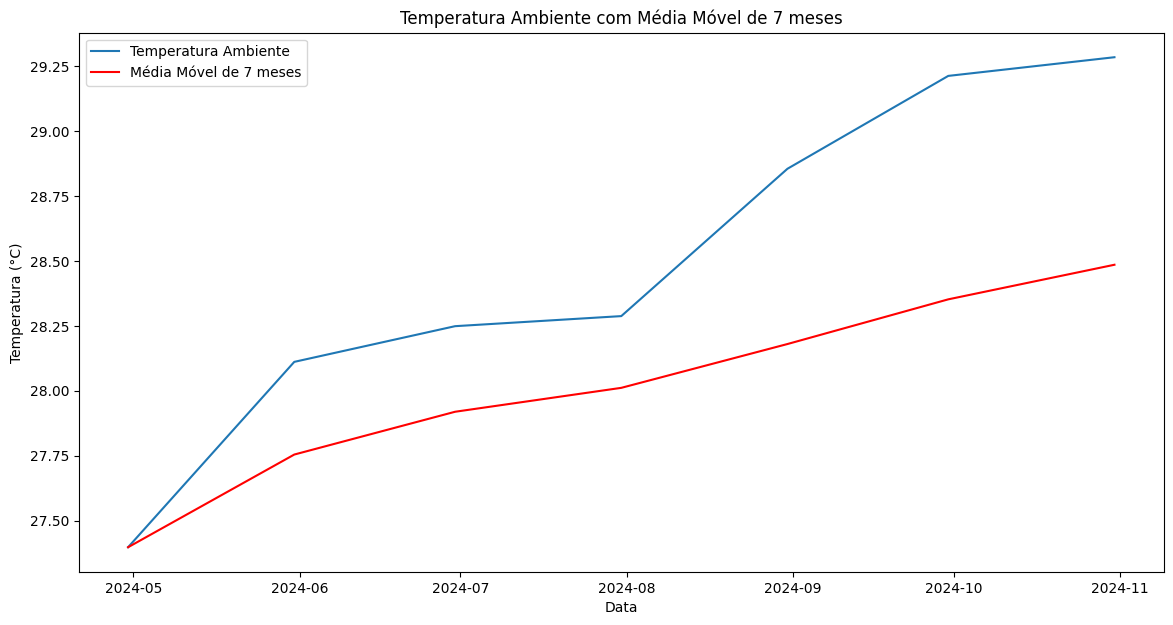

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['TAMB'], label='Temperatura Ambiente')
plt.plot(df_mensal.index, df_mensal['TAMB_MV_7M'], label='Média Móvel de 7 meses', color='red')
plt.title('Temperatura Ambiente com Média Móvel de 7 meses')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

Média móvel do GHI:

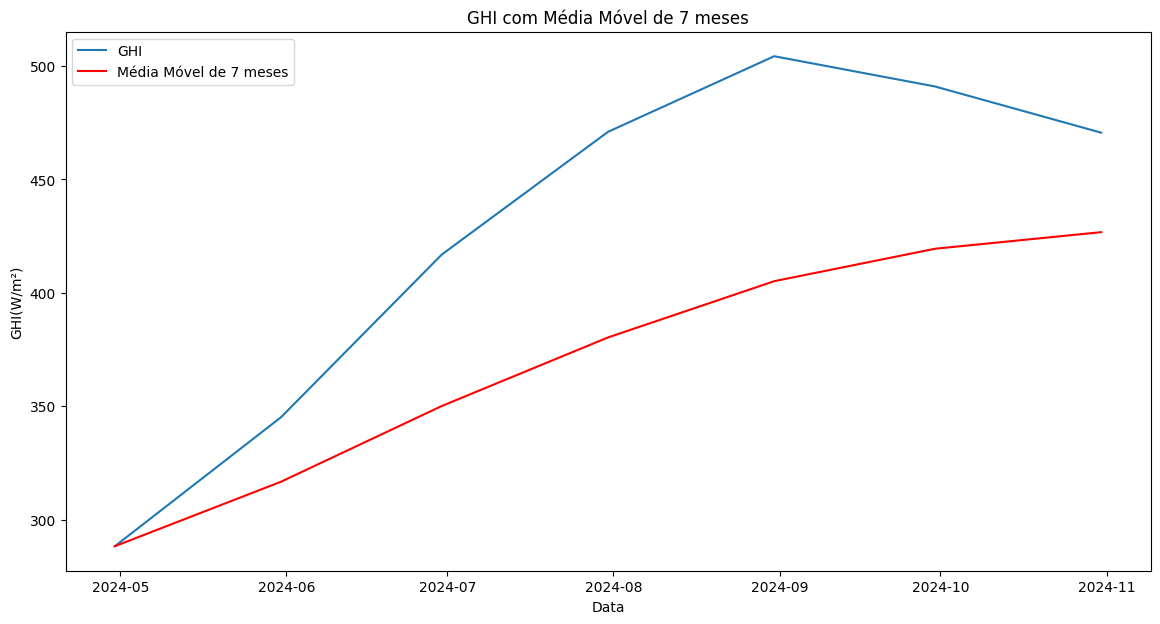

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['GHI'], label='GHI')
plt.plot(df_mensal.index, df_mensal['GHI_MV_7M'], label='Média Móvel de 7 meses', color='red')
plt.title('GHI com Média Móvel de 7 meses')
plt.xlabel('Data')
plt.ylabel('GHI(W/m²)')
plt.legend()
plt.show()

* Média móvel da umidade relativa do ar:

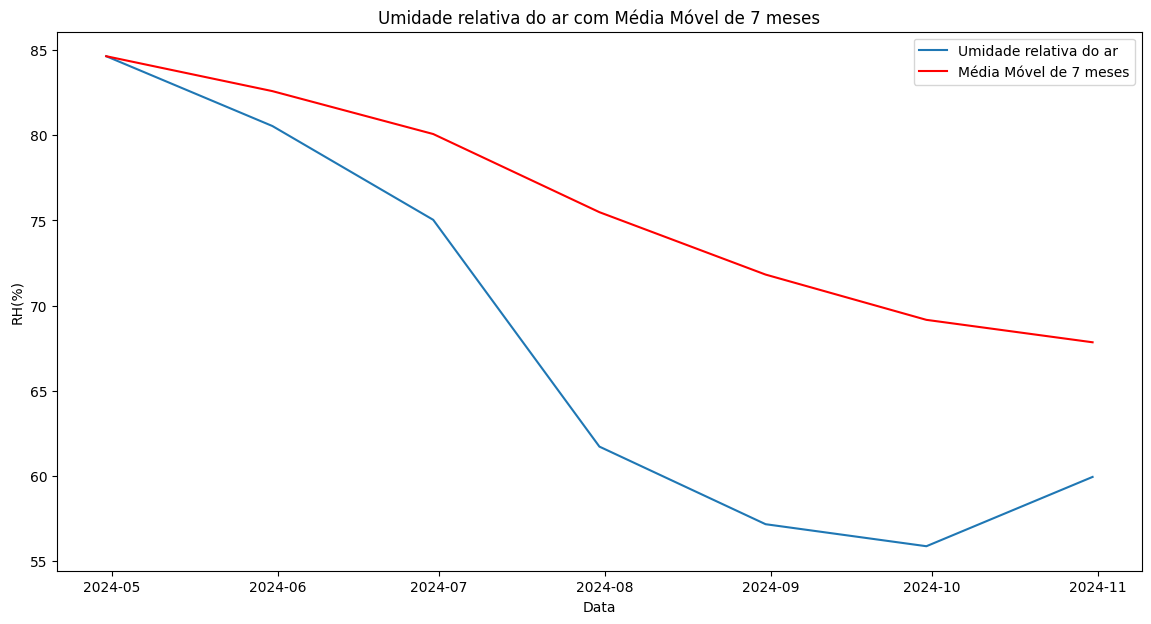

In [38]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['RH'], label='Umidade relativa do ar')
plt.plot(df_mensal.index, df_mensal['RH_MV_7M'], label='Média Móvel de 7 meses', color='red')
plt.title('Umidade relativa do ar com Média Móvel de 7 meses')
plt.xlabel('Data')
plt.ylabel('RH(%)')
plt.legend()
plt.show()

* Vamos novamente calcular as médias móveis de RH, TAMB e GHI, só que agora vamos utlizar o df_diario, para vê as sazonalidades, seja em uma semana ou nos trinta dias de um mês.

In [39]:
# Média móvel de 7 dias para suavizar oscilações semanais
df_diario['GHI_movel_7d'] = df_diario['GHI'].rolling(window=7, min_periods=1).mean()
df_diario['TAMB_movel_7d'] = df_diario['TAMB'].rolling(window=7, min_periods=1).mean()
df_diario['RH_movel_7d'] = df_diario['RH'].rolling(window=7, min_periods=1).mean()

# Média móvel de 30 dias para identificar tendências mensais
df_diario['GHI_movel_30d'] = df_diario['GHI'].rolling(window=30, min_periods=1).mean()
df_diario['TAMB_movel_30d'] = df_diario['TAMB'].rolling(window=30, min_periods=1).mean()
df_diario['RH_movel_30d'] = df_diario['RH'].rolling(window=30, min_periods=1).mean()

* Médias móveis de 7 e 30 dias do GHI:

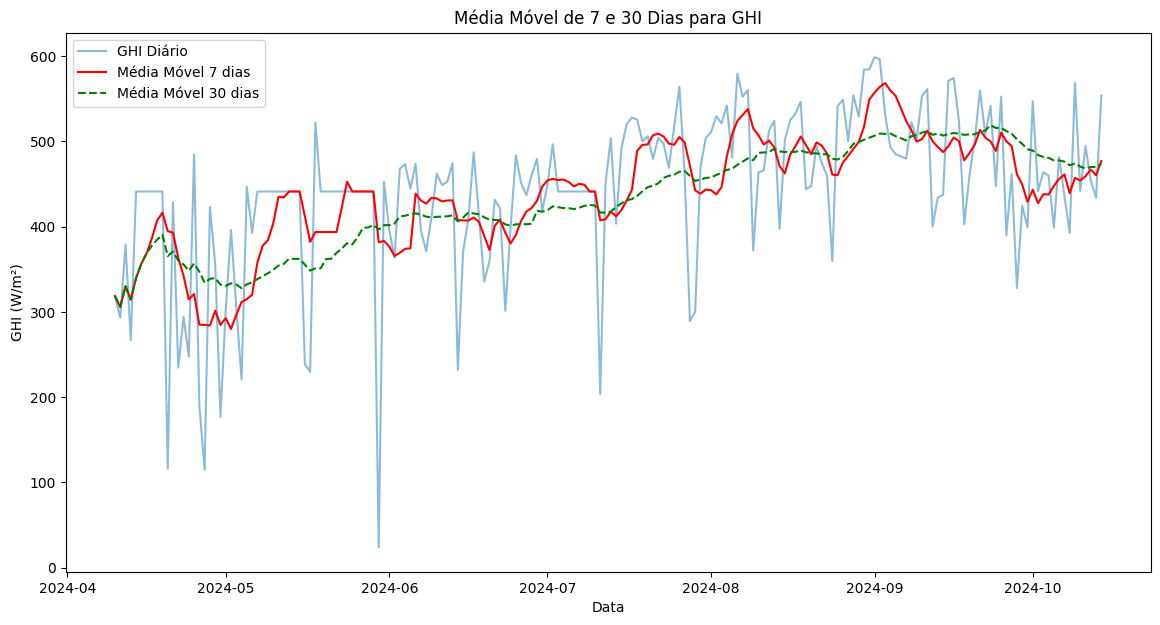

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(df_diario.index, df_diario['GHI'], label='GHI Diário', alpha=0.5)
plt.plot(df_diario.index, df_diario['GHI_movel_7d'], label='Média Móvel 7 dias', color='red')
plt.plot(df_diario.index, df_diario['GHI_movel_30d'], label='Média Móvel 30 dias', color='green', linestyle='dashed')
plt.title('Média Móvel de 7 e 30 Dias para GHI')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.show()

* Médias móveis de 7 e 30 dias da temperatura ambiente:

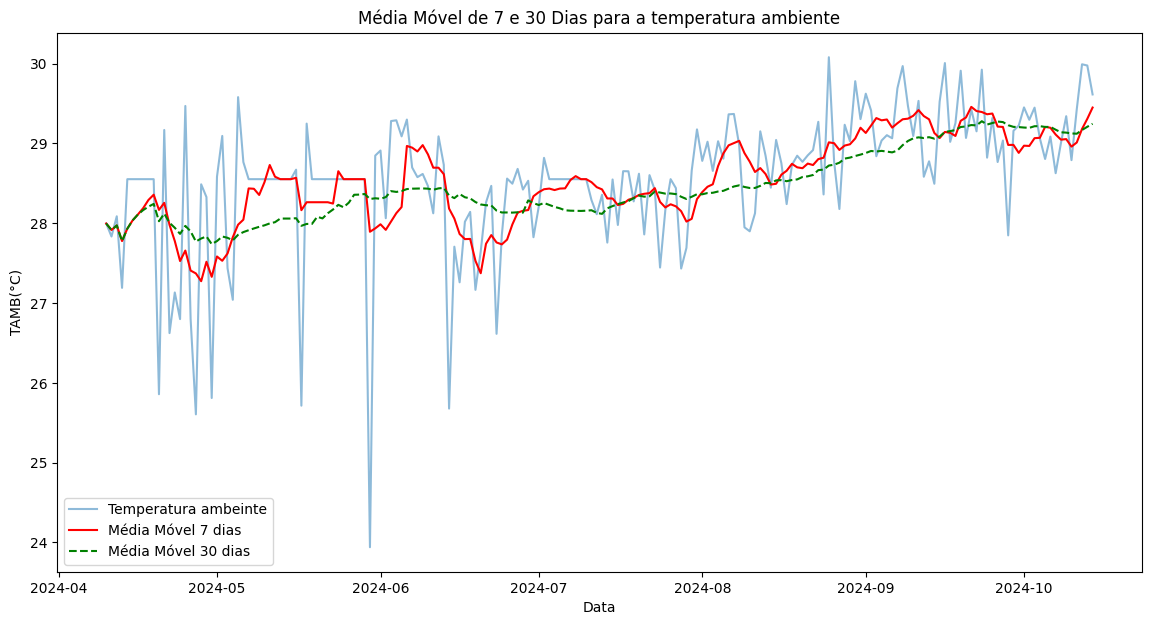

In [41]:
plt.figure(figsize=(14, 7))
plt.plot(df_diario.index, df_diario['TAMB'], label='Temperatura ambeinte', alpha=0.5)
plt.plot(df_diario.index, df_diario['TAMB_movel_7d'], label='Média Móvel 7 dias', color='red')
plt.plot(df_diario.index, df_diario['TAMB_movel_30d'], label='Média Móvel 30 dias', color='green', linestyle='dashed')
plt.title('Média Móvel de 7 e 30 Dias para a temperatura ambiente')
plt.xlabel('Data')
plt.ylabel('TAMB(°C)')
plt.legend()
plt.show()

* Médias móveis de 7 e 30 dias da umidade relativa do ar:

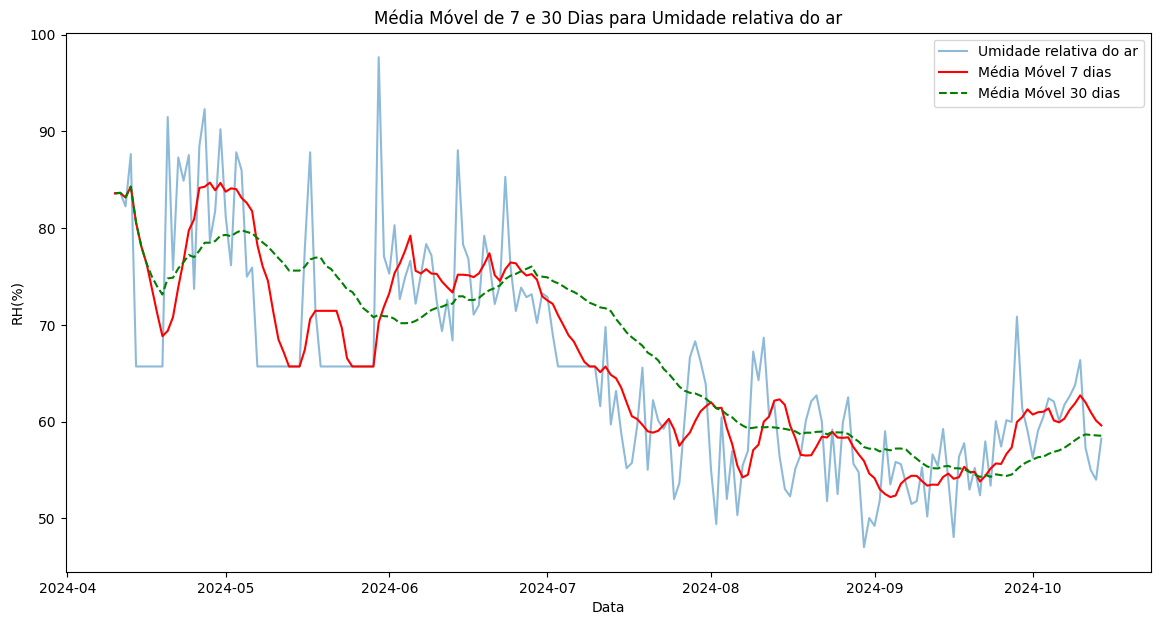

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(df_diario.index, df_diario['RH'], label='Umidade relativa do ar', alpha=0.5)
plt.plot(df_diario.index, df_diario['RH_movel_7d'], label='Média Móvel 7 dias', color='red')
plt.plot(df_diario.index, df_diario['RH_movel_30d'], label='Média Móvel 30 dias', color='green', linestyle='dashed')
plt.title('Média Móvel de 7 e 30 Dias para Umidade relativa do ar')
plt.xlabel('Data')
plt.ylabel('RH(%)')
plt.legend()
plt.show()

In [43]:
from prophet import Prophet

In [52]:
# Janela de 3 meses
df_mensal['GHI_mm3'] = df_mensal['GHI'].rolling(window=3,min_periods=1).mean()
df_mensal['TAMB_mm3'] = df_mensal['TAMB'].rolling(window=3, min_periods=1).mean()
df_mensal['RH_mm3'] = df_mensal['RH'].rolling(window=3, min_periods=1).mean()

In [56]:
# Janela de 7 dias (média móvel semanal)
df_diario['GHI_mm7'] = df_diario['GHI'].rolling(window=7, min_periods=1).mean()
df_diario['TAMB_mm7'] = df_diario['TAMB'].rolling(window=7, min_periods=1).mean()
df_diario['RH_mm7'] = df_diario['RH'].rolling(window=7, min_periods=1).mean()

# Janela de 30 dias (média móvel mensal)
df_diario['GHI_mm30'] = df_diario['GHI'].rolling(window=30, min_periods=1).mean()
df_diario['TAMB_mm30'] = df_diario['TAMB'].rolling(window=30, min_periods=1).mean()
df_diario['RH_mm30'] = df_diario['RH'].rolling(window=30, min_periods=1).mean()

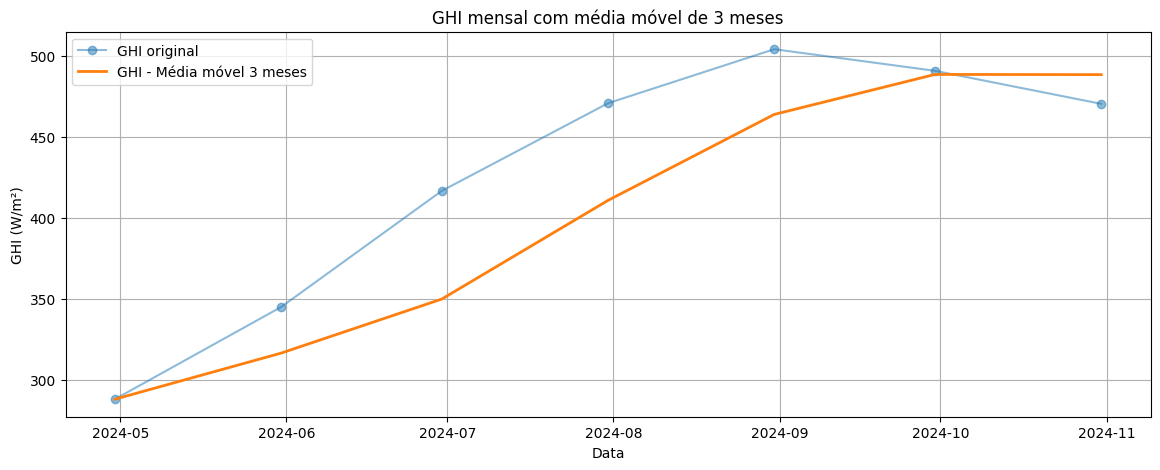

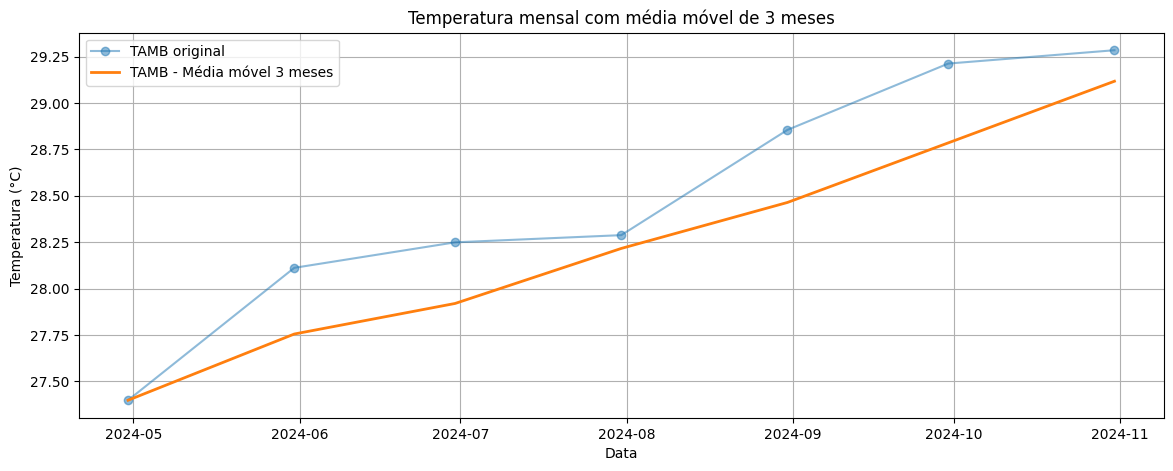

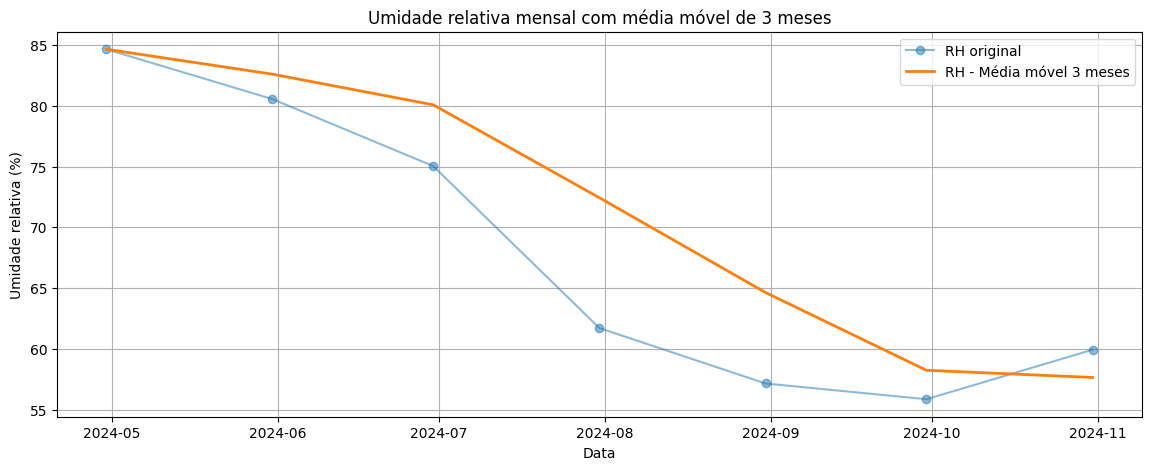

In [53]:
plt.figure(figsize=(14, 5))
plt.plot(df_mensal['GHI'], label='GHI original', marker='o', alpha=0.5)
plt.plot(df_mensal['GHI_mm3'], label='GHI - Média móvel 3 meses', linewidth=2)
plt.title('GHI mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_mensal['TAMB'], label='TAMB original', marker='o', alpha=0.5)
plt.plot(df_mensal['TAMB_mm3'], label='TAMB - Média móvel 3 meses', linewidth=2)
plt.title('Temperatura mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_mensal['RH'], label='RH original', marker='o', alpha=0.5)
plt.plot(df_mensal['RH_mm3'], label='RH - Média móvel 3 meses', linewidth=2)
plt.title('Umidade relativa mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()


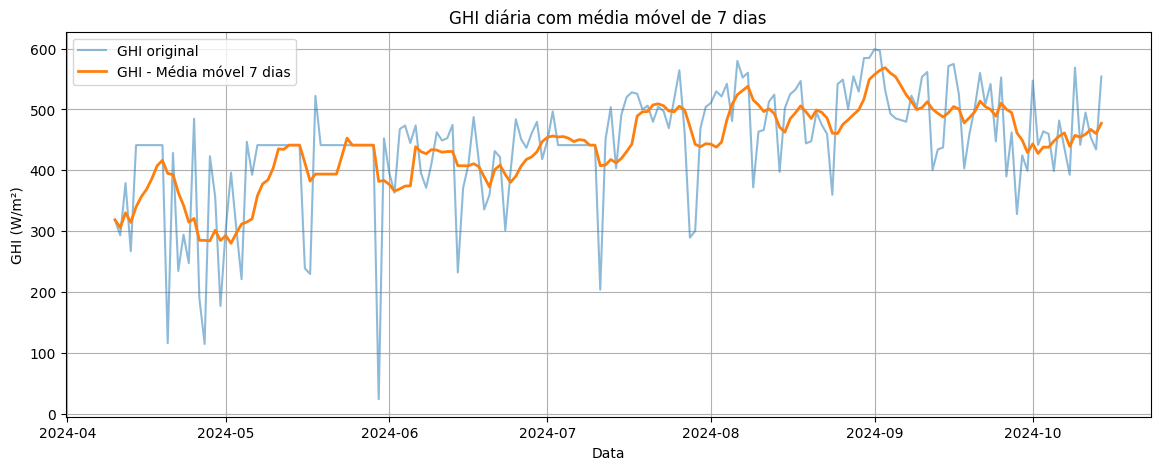

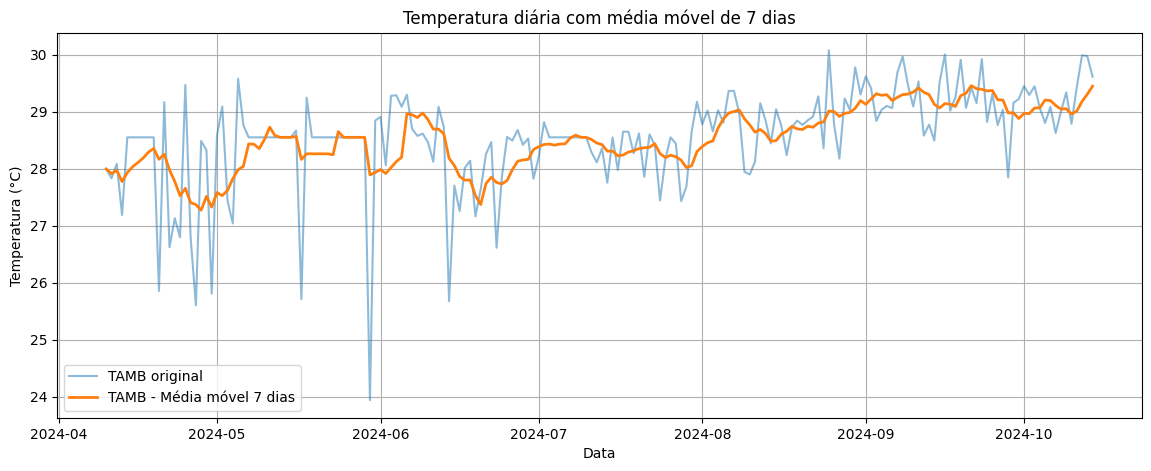

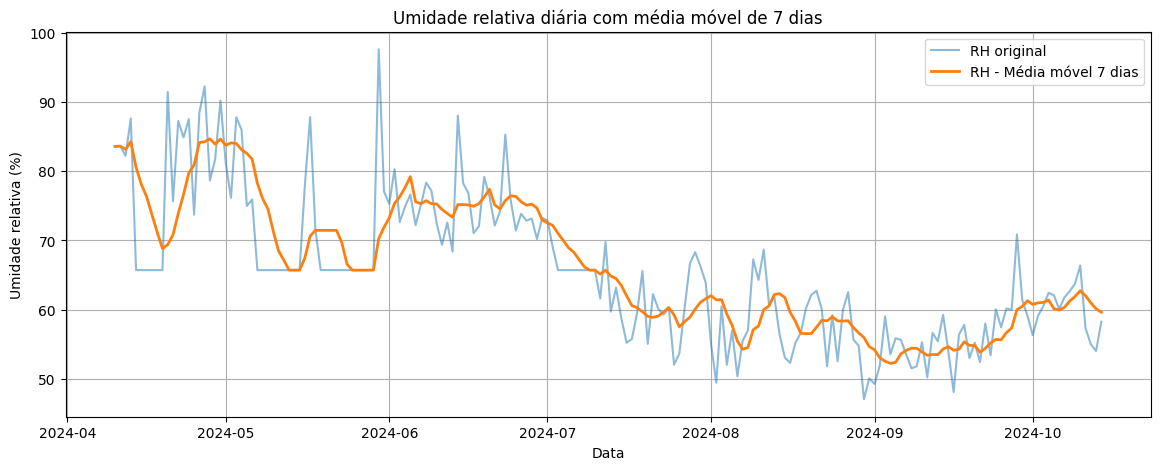

In [57]:
plt.figure(figsize=(14, 5))
plt.plot(df_diario['GHI'], label='GHI original', alpha=0.5)
plt.plot(df_diario['GHI_mm7'], label='GHI - Média móvel 7 dias', linewidth=2)
plt.title('GHI diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['TAMB'], label='TAMB original', alpha=0.5)
plt.plot(df_diario['TAMB_mm7'], label='TAMB - Média móvel 7 dias', linewidth=2)
plt.title('Temperatura diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['RH'], label='RH original', alpha=0.5)
plt.plot(df_diario['RH_mm7'], label='RH - Média móvel 7 dias', linewidth=2)
plt.title('Umidade relativa diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()


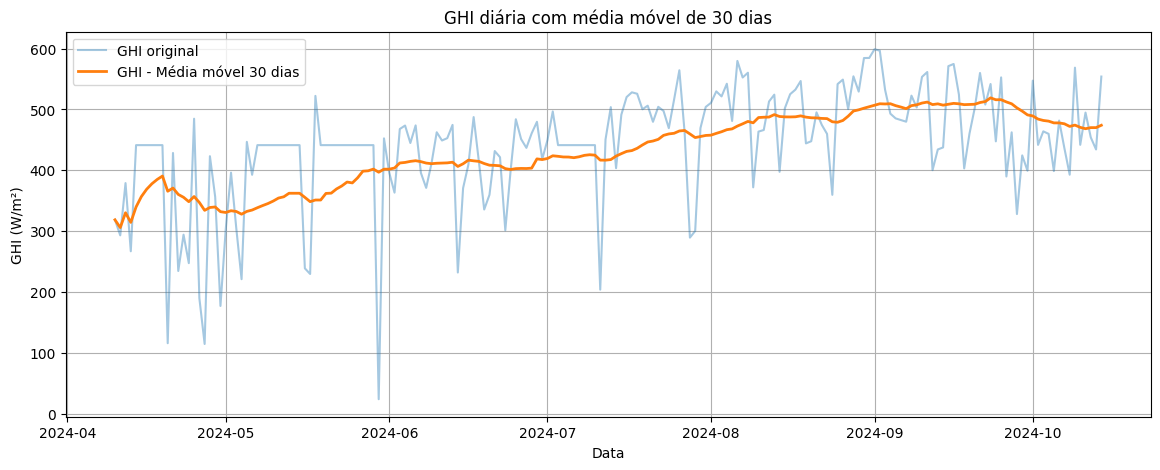

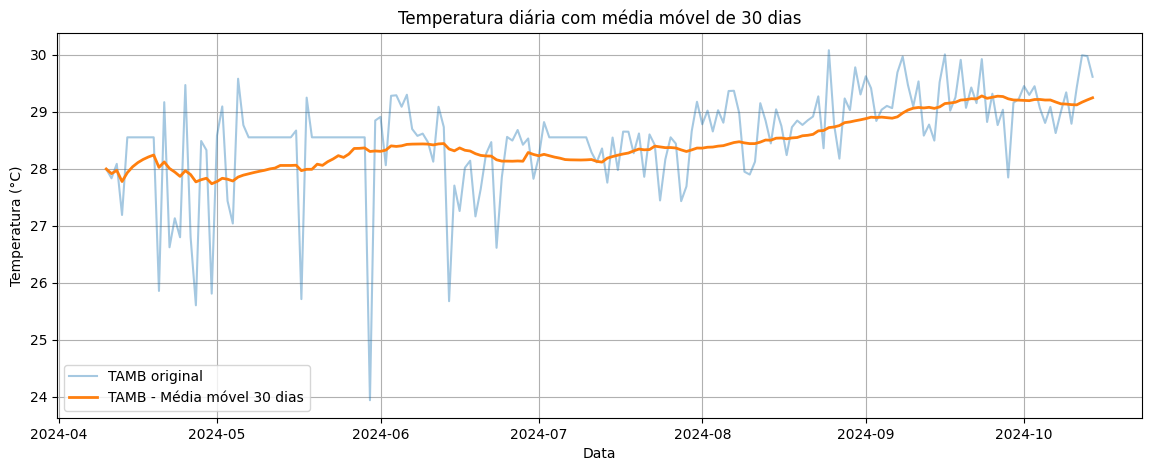

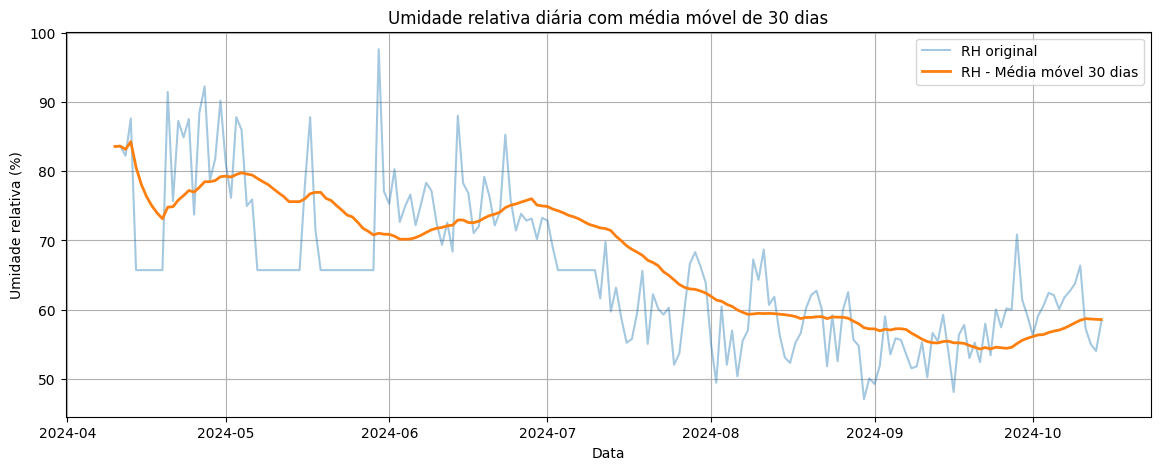

In [58]:
plt.figure(figsize=(14, 5))
plt.plot(df_diario['GHI'], label='GHI original', alpha=0.4)
plt.plot(df_diario['GHI_mm30'], label='GHI - Média móvel 30 dias', linewidth=2)
plt.title('GHI diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['TAMB'], label='TAMB original', alpha=0.4)
plt.plot(df_diario['TAMB_mm30'], label='TAMB - Média móvel 30 dias', linewidth=2)
plt.title('Temperatura diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['RH'], label='RH original', alpha=0.4)
plt.plot(df_diario['RH_mm30'], label='RH - Média móvel 30 dias', linewidth=2)
plt.title('Umidade relativa diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()
